In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly
import networkx as nx
import matplotlib.pyplot as plt

# Import Data

In [2]:
inpatients = pd.read_csv('./dataset/Train_Inpatientdata.csv')
outpatients = pd.read_csv('./dataset/Train_Outpatientdata.csv')
beneficiaries = pd.read_csv('./dataset/Train_Beneficiarydata.csv')
labels = pd.read_csv('./dataset/Train.csv')

In [3]:
inpatients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
BeneID                    40474 non-null object
ClaimID                   40474 non-null object
ClaimStartDt              40474 non-null object
ClaimEndDt                40474 non-null object
Provider                  40474 non-null object
InscClaimAmtReimbursed    40474 non-null int64
AttendingPhysician        40362 non-null object
OperatingPhysician        23830 non-null object
OtherPhysician            4690 non-null object
AdmissionDt               40474 non-null object
ClmAdmitDiagnosisCode     40474 non-null object
DeductibleAmtPaid         39575 non-null float64
DischargeDt               40474 non-null object
DiagnosisGroupCode        40474 non-null object
ClmDiagnosisCode_1        40474 non-null object
ClmDiagnosisCode_2        40248 non-null object
ClmDiagnosisCode_3        39798 non-null object
ClmDiagnosisCode_4        38940 non-null object
ClmDiagnosisCode_5        37

In [4]:
outpatients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
BeneID                    517737 non-null object
ClaimID                   517737 non-null object
ClaimStartDt              517737 non-null object
ClaimEndDt                517737 non-null object
Provider                  517737 non-null object
InscClaimAmtReimbursed    517737 non-null int64
AttendingPhysician        516341 non-null object
OperatingPhysician        90617 non-null object
OtherPhysician            195046 non-null object
ClmDiagnosisCode_1        507284 non-null object
ClmDiagnosisCode_2        322357 non-null object
ClmDiagnosisCode_3        203257 non-null object
ClmDiagnosisCode_4        125596 non-null object
ClmDiagnosisCode_5        74344 non-null object
ClmDiagnosisCode_6        48756 non-null object
ClmDiagnosisCode_7        32961 non-null object
ClmDiagnosisCode_8        22912 non-null object
ClmDiagnosisCode_9        14838 non-null object
ClmDiagnosisCo

In [5]:
beneficiaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
BeneID                             138556 non-null object
DOB                                138556 non-null object
DOD                                1421 non-null object
Gender                             138556 non-null int64
Race                               138556 non-null int64
RenalDiseaseIndicator              138556 non-null object
State                              138556 non-null int64
County                             138556 non-null int64
NoOfMonths_PartACov                138556 non-null int64
NoOfMonths_PartBCov                138556 non-null int64
ChronicCond_Alzheimer              138556 non-null int64
ChronicCond_Heartfailure           138556 non-null int64
ChronicCond_KidneyDisease          138556 non-null int64
ChronicCond_Cancer                 138556 non-null int64
ChronicCond_ObstrPulmonary         138556 non-null int64
ChronicCond_Depression          

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
Provider          5410 non-null object
PotentialFraud    5410 non-null object
dtypes: object(2)
memory usage: 84.6+ KB


# Merge Datasets

In [7]:
# Concatenate inpatient with outpatient data
df = pd.concat(
    [
        inpatients[["BeneID", "ClaimID", "ClaimStartDt", "ClaimEndDt", "Provider", "AttendingPhysician"]],
        outpatients[["BeneID", "ClaimID", "ClaimStartDt", "ClaimEndDt", "Provider", "AttendingPhysician"]]
    ], axis=0
)
df["ClaimStartDt"] = pd.to_datetime(df["ClaimStartDt"])
df["ClaimEndDt"] = pd.to_datetime(df["ClaimEndDt"])

print(df.shape)
df.head()

(558211, 6)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,AttendingPhysician
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,PHY390922
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,PHY318495
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,PHY372395
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,PHY369659
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,PHY379376


In [8]:
df = pd.merge(
    df,
    labels,
    on="Provider",
    how="inner"
)

df["PotentialFraud"] = df["PotentialFraud"].replace("No", 0).replace("Yes", 1).astype(int)

print(df.shape)
df.head()

(558211, 7)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,AttendingPhysician,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,PHY390922,1
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,PHY349293,1
2,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,PHY334706,1
3,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,PHY390614,1
4,BENE24402,CLM32911,2009-01-08,2009-01-12,PRV55912,PHY380413,1


# Fraud by AttendingPhysician

Let's look at how many claims each physician has and what fraction of them are fraudulent.

In [9]:
df_agg_physician = df.groupby(["AttendingPhysician"]).agg({
    "ClaimID": "nunique",
    "ClaimStartDt": "min",
    "Provider": "nunique",
    "PotentialFraud": "mean",
}).rename(
    columns={"ClaimID": "num_claims", "ClaimStartDt": "earliest_claim", "Provider": "num_providers", "PotentialFraud": "fraction_fraud"}
).sort_values("num_claims", ascending=False).reset_index()

df_agg_physician.head()

,AttendingPhysician,earliest_claim,fraction_fraud,num_claims,num_providers
0,PHY330576,2008-12-16,1.0,2534,1
1,PHY350277,2008-12-15,1.0,1628,1
2,PHY412132,2008-12-14,1.0,1321,1
3,PHY423534,2008-12-17,1.0,1223,1
4,PHY314027,2008-12-30,1.0,1200,1


In [10]:
df_agg_physician.shape

(82063, 5)

Text(0.5,1,'Histogram of Fraction of Fraudulent Claims per Physician')

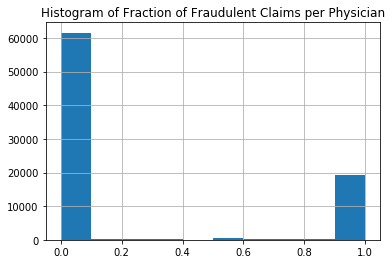

In [11]:
df_agg_physician.fraction_fraud.hist()
plt.title("Histogram of Fraction of Fraudulent Claims per Physician")

Text(0.5,1,'Histogram of # of Claims for Physicians with Fraudulent Claims')

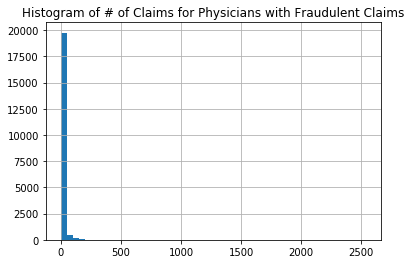

In [12]:
df_agg_physician[df_agg_physician.fraction_fraud > 0]["num_claims"].hist(bins=50)
plt.title("Histogram of # of Claims for Physicians with Fraudulent Claims")

In [13]:
df_agg_physician[df_agg_physician.fraction_fraud > 0]["num_claims"].describe()

count    20592.000000
mean        10.740967
std         49.950534
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       2534.000000
Name: num_claims, dtype: float64

## Select Top Fraudulent Physicians

Looks like the majority of physicians have a small number of claims - top 25% of physicians have 5+ claims. Let's look at the top fraudulent physician with the most claims and see how big this cluster is.

In [40]:
df.columns

Index([u'BeneID', u'ClaimID', u'ClaimStartDt', u'ClaimEndDt', u'Provider',
       u'AttendingPhysician', u'PotentialFraud'],
      dtype='object')

In [14]:
def get_fraud_cluster(AttendingPhysician, MaxHops):
    """
    Returns fraudulent claims associated with the given AttendingPhysician 
    and beneficiaries served up to a maximum number of hops or convergence
    
        Parameters:
            AttendingPhysician (str): ID of attending physician to start with as the root node.
            MaxHops (int): Maximum number of hops.
            
        Returns:
            df (DataFrame): A Pandas Dataframe containing fraudulent claims associated 
            with supplied AttendingPhysician up to a maximum number of hops away.
    """
    
    prev_cluster_size = 0
    current_cluster_size = 1
    i = 0
    
    set_physicians = set([AttendingPhysician])
    set_beneficiaries = set()
    
    while prev_cluster_size < current_cluster_size and i < MaxHops:
        print("Round ", i, ", # of Physicians: ", len(set_physicians), ", # of Beneficiaries: ", len(set_beneficiaries))

        prev_cluster_size = len(set_physicians) + len(set_beneficiaries)
        
        # Get fraudulent physicians with claims associated with fraudulent beneficiaries
        fraud_physicians = df[
            (df.BeneID.isin(set_beneficiaries)) &
            (df.PotentialFraud == 1)
        ]["AttendingPhysician"].unique()
        new_fraud_physicians = set(fraud_physicians).difference(set_physicians)
        
        # Update set with new fraudulent physicians
        set_physicians.update(new_fraud_physicians)
        
        # Get fraudulent beneficiaries with claims associated with fraudulent physicians
        fraud_beneficiaries = df[
            (df.AttendingPhysician.isin(set_physicians)) &
            (df.PotentialFraud == 1)
        ]["BeneID"].unique()
        new_fraud_beneficiaries = set(fraud_beneficiaries).difference(set_beneficiaries)
        # Upate set with new fraudulent beneficiaries
        set_beneficiaries.update(new_fraud_beneficiaries)
        
        # update variables
        i += 1
        current_cluster_size = len(set_physicians) + len(set_beneficiaries)
        
    df_results = df[
        (df.AttendingPhysician.isin(set_physicians)) &
        (df.BeneID.isin(set_beneficiaries)) &
        (df.PotentialFraud == 1)
    ]
    
    return df_results

    

In [15]:
# RootPhysicianID = "PHY421580"

# Choose a random physicianID with fraudulent claims to start with
RootPhysicianID = df_agg_physician[
    df_agg_physician.fraction_fraud > 0
].sample(1).iloc[0]["AttendingPhysician"]

In [16]:
RootPhysicianID

'PHY379763'

In [42]:
df_agg_physician[df_agg_physician.AttendingPhysician == RootPhysicianID]

,AttendingPhysician,earliest_claim,fraction_fraud,num_claims,num_providers
38314,PHY379763,2009-04-25,1.0,2,1


In [17]:
df_results = get_fraud_cluster(AttendingPhysician=RootPhysicianID, MaxHops=2)

('Round ', 0, ', # of Physicians: ', 1, ', # of Beneficiaries: ', 0)
('Round ', 1, ', # of Physicians: ', 1, ', # of Beneficiaries: ', 2)


In [18]:
df_results.shape

(1483, 7)

In [19]:
df_results.BeneID.nunique()

920

In [20]:
df_results.AttendingPhysician.nunique()

3

# Create Time-series Network Graph

Choose colors/ hex codes that go well together: https://palettes.shecodes.io/

In [21]:
color_mappings = {
    "BeneID": "#66bfbf", # teal green
    "AttendingPhysician": "#fecea8",  # light orange
    "RootPhysician": "#f76b8a", # pinkish red
}

In [31]:
def plot_graph(G, pos, fig):
    # Select nodes
    node_x = [pos[node][0] for node in G.nodes() if node in pos]
    node_y = [pos[node][1] for node in G.nodes() if node in pos]
    
    # Select edges
    edge_x = []
    edge_y = []
    for u, v, label in G.edges(data=True):
        if u in pos and v in pos:
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            
    # Additional text to show on hover
    node_text = [data["label"] for node, data in G.nodes(data=True)]
    node_colors = [color_mappings.get(data["label"][0]) for node, data in G.nodes(data=True)]
    
    # Add nodes and edges to plot
    fig.add_trace(
        go.Scatter(
            x=edge_x, 
            y=edge_y,
            mode="lines",
            line=dict(color="gray"),
            name="Edges"
        )
    )
    fig.add_trace(
        go.Scatter(
            x=node_x,
            y=node_y,
            mode="markers",
            marker=dict(size=10, color=node_colors),
            text=node_text,
            hoverinfo="text",
            opacity=0.8,
            name="Nodes",
        )
    )
    
    return fig

In [32]:
def plot_time_series_graph(df, RootPhysicianID=None):
    # Convert date column 
    df["ClaimStartDt"] = pd.to_datetime(df["ClaimStartDt"])
    
    # Initialize new figure
    fig = go.Figure()
    
    # Initialize empty graph
    G = nx.Graph()
    
    # Build graph from df
    for row in df.itertuples():
        G.add_node(row.BeneID, label=("BeneID", row.BeneID, row.ClaimStartDt))
        # Assign a different node label (for node color later on) for root Physician
        if RootPhysicianID and row.AttendingPhysician == RootPhysicianID:
            G.add_node(row.AttendingPhysician, label=("RootPhysician", row.AttendingPhysician, row.ClaimStartDt))
        else:
            G.add_node(row.AttendingPhysician, label=("AttendingPhysician", row.AttendingPhysician, row.ClaimStartDt))
        G.add_edge(row.BeneID, row.AttendingPhysician, label=(row.BeneID, row.AttendingPhysician, row.ClaimStartDt))
            
    # get positions
    pos = nx.spring_layout(G)
    
    print("Finished building graph (G).")
    
    # Grab unique months in dataset 
    months = [
        i.to_timestamp("D") for i in pd.to_datetime(
            df["ClaimStartDt"]
        ).dt.to_period("M").sort_values().unique()
     ]
    
    # Loop through months
    for month in months:
        month_str = month.strftime("%Y-%m")
        
        # Duplicate original graph for a new graph in current month
        new_G = G.copy()
        
        # Extract nodes and edges to remove
        nodes_to_remove = [
            node for node in new_G.nodes() 
            if "label" in new_G.nodes[node] 
            and new_G.nodes[node]["label"][-1] >= month
        ]
        edges_to_remove = [
            (u, v) for u, v, data in new_G.edges(data=True) 
            if "label" in data and data["label"][-1] >= month
        ]
        
        # Remove self-loops
        for u, v, label in new_G.edges(data=True):
            if u == v:
                new_G.remove_edge(u, v)
                
        # Remove nodes and edges from new graph
        new_G.remove_edges_from(edges_to_remove)
        new_G.remove_nodes_from(nodes_to_remove)
        
        # Plot new graph for this month and add to figure
        fig = plot_graph(G=new_G, pos=pos, fig=fig)
        
        print("Finished plotting graph for %s." % month)
    
    # Configure slider
    steps = []
    for i, month in enumerate(months):
        idx = i * 2   # multiply by 2 because one trace is for nodes and one is for edges
        month_str = month.strftime("%Y-%m")
        visibility = [False] * len(months) * 2   # Make all traces not visible by default
        visibility[idx] = True   # Make trace for nodes visible
        visibility[idx + 1] = True    # Make trace for edges visible
        step = dict(
            method="update",
            label="Month: %s" % month_str,
            args=[{"visible": visibility}],
        )
        steps.append(step)
        
    # Make first graph visible
    fig.data[1].visible = True
        
    # Update figure settings
    fig.update_layout(
        title="Time Series Graph Visualization for Root PhysicianID = %s" % RootPhysicianID,
        showlegend=False,
        hovermode="closest",
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        sliders=[
            dict(
                active=0,
                steps=steps,
                pad={"t": 50}
            ),
        ],
    )
    
    return fig
        

In [33]:
start_date = df_results[df_results.AttendingPhysician == RootPhysicianID]["ClaimStartDt"].min()

print(start_date)

2009-04-25 00:00:00


In [34]:
df_results_filtered = df_results[
    df_results.ClaimStartDt >= start_date
]

In [39]:
print(df_results_filtered.shape)

df_results_filtered.head()

(989, 7)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,AttendingPhysician,PotentialFraud
102136,BENE30109,CLM48446,2009-04-25,2009-04-29,PRV51584,PHY379763,1
102138,BENE73880,CLM52207,2009-05-22,2009-05-24,PRV51584,PHY379763,1
351670,BENE11197,CLM378723,2009-05-25,2009-05-25,PRV51574,PHY387395,1
351684,BENE11395,CLM501837,2009-08-01,2009-08-01,PRV51574,PHY415321,1
351686,BENE11395,CLM599837,2009-09-26,2009-09-26,PRV51574,PHY387395,1


In [35]:
fig = plot_time_series_graph(
    df=df_results_filtered, 
    RootPhysicianID=RootPhysicianID
)

/Users/clau/Documents/Python/DS_Portfolio/fraud_healthcare/env_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Finished building graph (G).
Finished plotting graph for 2009-04-01 00:00:00.
Finished plotting graph for 2009-05-01 00:00:00.
Finished plotting graph for 2009-06-01 00:00:00.
Finished plotting graph for 2009-07-01 00:00:00.
Finished plotting graph for 2009-08-01 00:00:00.
Finished plotting graph for 2009-09-01 00:00:00.
Finished plotting graph for 2009-10-01 00:00:00.
Finished plotting graph for 2009-11-01 00:00:00.
Finished plotting graph for 2009-12-01 00:00:00.


In [36]:
fig.show()

In [37]:
RootPhysicianID

'PHY379763'

In [38]:
# html file
plotly.offline.plot(fig, filename="./graph_viz_PHY379763.html")

'./graph_viz_PHY379763.html'